In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt

In [3]:
path = '../dataset/revision/'
target_date = '2024-08-12'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.4389,0.5398,0.1780,0.4561,-1.0595,6.4718,180.0876
1,6.028,0.4384,0.5399,0.1761,0.4560,-0.8981,7.1419,180.1376
2,6.078,0.4385,0.5399,0.1758,0.4560,-0.8437,7.9602,180.1347
3,6.128,0.4384,0.5399,0.1766,0.4561,-1.0247,8.5293,180.2354
4,6.178,0.4383,0.5399,0.1760,0.4563,-1.2691,9.0962,180.2350
...,...,...,...,...,...,...,...,...
12281,963.178,0.4038,0.5481,0.2839,0.4633,-0.9163,50.2852,94.4888
12282,963.228,0.4030,0.5480,0.2841,0.4631,-0.2081,50.1978,95.0078
12283,963.278,0.4028,0.5479,0.2843,0.4631,0.3667,50.2312,95.5391
12284,963.328,0.4028,0.5478,0.2843,0.4634,-0.5126,50.3408,94.8635


In [10]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [12]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal

high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.438900,0.539800,0.178000,0.456100,-1.059500,6.471800,180.087600
1,5.980,0.438887,0.539804,0.177888,0.456096,-1.049486,6.518270,180.086592
2,5.981,0.438874,0.539807,0.177779,0.456092,-1.039741,6.563907,180.085691
3,5.982,0.438862,0.539810,0.177674,0.456088,-1.030262,6.608719,180.084896
4,5.983,0.438850,0.539814,0.177572,0.456084,-1.021046,6.652716,180.084206
...,...,...,...,...,...,...,...,...
957345,963.324,0.402878,0.547874,0.284701,0.463518,-0.085391,50.209149,95.249080
957346,963.325,0.402882,0.547879,0.284719,0.463515,-0.039246,50.201299,95.288207
957347,963.326,0.402886,0.547884,0.284739,0.463512,0.008993,50.193182,95.329085
957348,963.327,0.402891,0.547889,0.284759,0.463508,0.059360,50.184795,95.371742


In [73]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,0.000343,0.000083,0.000938,-0.000221,-0.185045,0.184167,-0.228084
1,0.001,0.000337,0.000084,0.000909,-0.000222,-0.180210,0.195814,-0.227744
2,0.002,0.000332,0.000086,0.000880,-0.000223,-0.175305,0.207627,-0.227394
3,0.003,0.000326,0.000088,0.000850,-0.000224,-0.170339,0.219589,-0.227035
4,0.004,0.000320,0.000090,0.000820,-0.000225,-0.165317,0.231683,-0.226667
...,...,...,...,...,...,...,...,...
957345,957.345,-0.000005,-0.000005,-0.000013,-0.000009,0.004749,0.002773,0.004161
957346,957.346,-0.000005,-0.000005,-0.000012,-0.000008,0.004138,0.002441,0.003624
957347,957.347,-0.000004,-0.000004,-0.000010,-0.000007,0.003580,0.002131,0.003133
957348,957.348,-0.000003,-0.000004,-0.000009,-0.000006,0.003071,0.001844,0.002687


In [74]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

# Swallow

## level 3

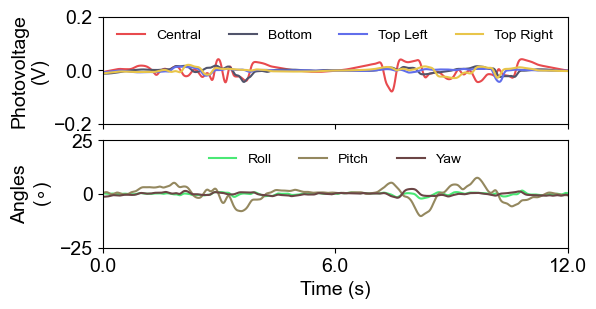

In [154]:
start = 155
offset = 20

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/lvl3.png', bbox_inches='tight', dpi=600)
plt.show()

## level 4

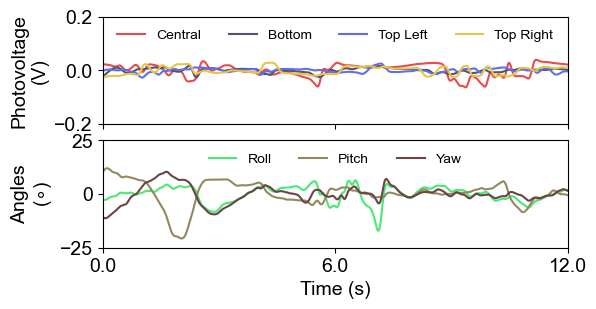

In [155]:
start = 155
offset = 116

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/lvl4.png', bbox_inches='tight', dpi=600)
plt.show()

## level 5

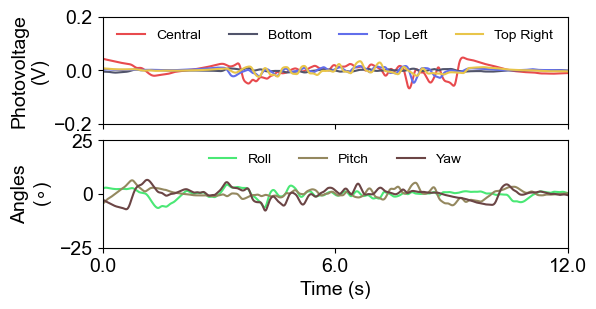

In [156]:
start = 155
offset = 197

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/lvl5.png', bbox_inches='tight', dpi=600)
plt.show()

## level 6

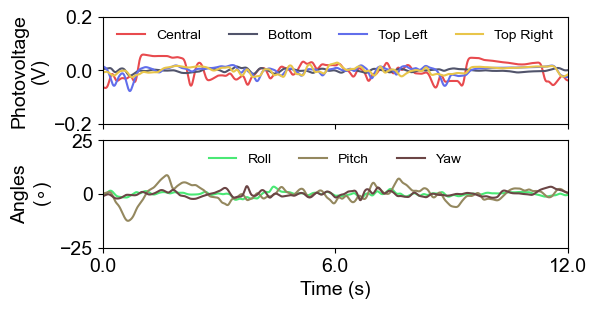

In [157]:
start = 155
offset = 260

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/lvl6.png', bbox_inches='tight', dpi=600)
plt.show()

## level 7

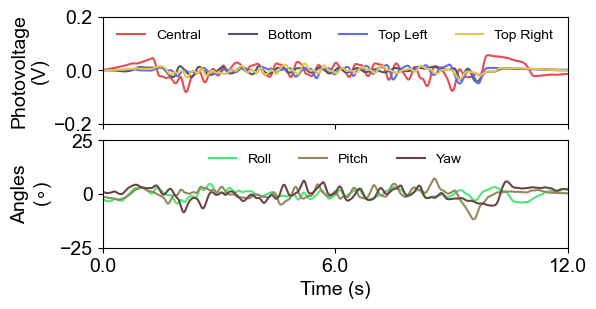

In [158]:
start = 155
offset = 303

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/lvl7.png', bbox_inches='tight', dpi=600)
plt.show()